## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.


In [86]:
### Environment setup
from pystac_client import Client
import planetary_computer as pc
import os

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value

In [102]:
import fsspec
storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}

In [104]:
fs = fsspec.filesystem('az', account_name=storage_options['account_name'], account_key=storage_options['account_key'])

In [113]:
dirc = 'hls_output_2021-05-13'
raw_tifs = fs.ls(f'fia/{dirc}')


['fia/hls_output_2021-05-13/2016_10SDH.tif',
 'fia/hls_output_2021-05-13/2016_10SDJ.tif',
 'fia/hls_output_2021-05-13/2016_10SEF.tif',
 'fia/hls_output_2021-05-13/2016_10SEG.tif',
 'fia/hls_output_2021-05-13/2016_10SEH.tif',
 'fia/hls_output_2021-05-13/2016_10SEJ.tif',
 'fia/hls_output_2021-05-13/2016_10SFE.tif',
 'fia/hls_output_2021-05-13/2016_10SFF.tif',
 'fia/hls_output_2021-05-13/2016_10SFG.tif',
 'fia/hls_output_2021-05-13/2016_10SFH.tif',
 'fia/hls_output_2021-05-13/2016_10SFJ.tif',
 'fia/hls_output_2021-05-13/2016_10SGD.tif',
 'fia/hls_output_2021-05-13/2016_10SGE.tif',
 'fia/hls_output_2021-05-13/2016_10SGF.tif',
 'fia/hls_output_2021-05-13/2016_10SGG.tif',
 'fia/hls_output_2021-05-13/2016_10SGH.tif',
 'fia/hls_output_2021-05-13/2016_10SGJ.tif',
 'fia/hls_output_2021-05-13/2016_10TCK.tif',
 'fia/hls_output_2021-05-13/2016_10TCL.tif',
 'fia/hls_output_2021-05-13/2016_10TCM.tif',
 'fia/hls_output_2021-05-13/2016_10TCN.tif',
 'fia/hls_output_2021-05-13/2016_10TCP.tif',
 'fia/hls_

### Choose a region and time of interest

Choose a test area from the USGS data, we will repeat later for Brazil
but deciding our range around the station is important and should be discussed with the team

In [26]:
import pandas as pd
import fsspec
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

from PIL import Image
import matplotlib.pyplot as plt

container = 'usgs-data'

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}
fs = fsspec.filesystem('az', account_name=storage_options['account_name'], account_key=storage_options['account_key'])
station_url = f'az://{container}/station_metadata.csv'
station_df = pd.read_csv(station_url, storage_options=storage_options)                
fs_list = fs.ls('usgs-data/stations')
station_list = pd.DataFrame({'site_no':filter(None,\
                           map(lambda sub:(''.join([ele for ele in sub if ele.isnumeric()])), fs_list))}).astype('int')
filtered_station_df = station_list.merge(station_df, on='site_no')
#filter the stations to ones with data

crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(filtered_station_df,\
                       geometry=gpd.points_from_xy(filtered_station_df.Longitude, filtered_station_df.Latitude))
buffer_style = {'round':1,'flat':2,'square':3}
buffer = 0.005
gdf.geometry = gdf.geometry.buffer(buffer, cap_style = buffer_style['square'], resolution=1)

gdf = gdf.drop_duplicates()

In [27]:
def get_spacetime_bounds(station):
    coordinates =  np.dstack(station.geometry.boundary.coords.xy).tolist()
    area_of_interest = {
        "type": "Polygon",
        "coordinates": coordinates,
    }
    start = df['Date-Time'].iloc[0].strftime('%Y-%m-%d')
    end = df['Date-Time'].iloc[-1].strftime('%Y-%m-%d')
    #use the date range of the data?
    #time_of_interest = "2019-06-01/2019-08-01"
    time_of_interest = f'{start}/{end}'
    return area_of_interest, time_of_interest

def build_catalog(area_of_interest, time_of_interest,collection='sentinel-2-l2a'):
    ''' 
    Use pystac-client to search for Sentinel 2 L2A data
    '''
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=[collection], 
        intersects=area_of_interest, 
        datetime=time_of_interest    
    )
    print(f"{search.matched()} Items found")
    return search

def get_scl_chip(signed_url, area_of_interest, write_to_filename=None):
    with rasterio.open(signed_url) as ds:    
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(window=aoi_window)
        scl = band_data[0].repeat(2, axis=0).repeat(2, axis=1)
        return scl
    
def get_visual_chip(signed_url, area_of_interest, write_to_filename=None):
    with rasterio.open(signed_url) as ds:    
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(window=aoi_window)
        img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
        #w = img.size[0]; h = img.size[1]; aspect = w/h
        #target_w = scl.shape[1]; target_h = scl.shape[0]
        #img = img.resize((target_w,target_h),Image.BILINEAR)
        return img
    
def get_filtered_cloud_list(search, cloud_thr):
    scene_list = sorted(search.items(), key=lambda item: item.ext.eo.cloud_cover)
    cloud_list = pd.DataFrame([{'Date-Time':s.datetime.strftime('%Y-%m-%d'),\
                            'Cloud Cover':s.ext.eo.cloud_cover,\
                            'visual-href':s.assets['visual-10m'].href,\
                            'scl-href':s.assets['SCL-20m'].href} for s in scene_list if s.ext.eo.cloud_cover<cloud_thr])
    cloud_list['Date-Time'] = pd.to_datetime(cloud_list['Date-Time'])
    return cloud_list

def chip_cloud_analysis(scl):
    n_total_pxls = np.multiply(scl.shape[0], scl.shape[1])
    n_cloud_pxls = np.sum((scl>=7) & (scl<=10))
    chip_cloud_pct = 100*(n_cloud_pxls/n_total_pxls)
    return chip_cloud_pct


In [32]:
#iterate here for writing the data
for i, station in gdf[21:22].iterrows():
    url = f'az://{container}/stations/{str(station.site_no).zfill(8)}_data.csv' #zero pad 8 digits for site_no
    df = pd.read_csv(url, storage_options=storage_options) 
    df['Date-Time'] = pd.to_datetime(df['Date-Time'])
    df = df.sort_values(by='Date-Time')
    #Define the aoi and time range to filter images with. 
    area_of_interest, time_of_interest = get_spacetime_bounds(station)
    search = build_catalog(area_of_interest, time_of_interest)
    cloud_thr = 100 #set threshold high
    cloud_list = get_filtered_cloud_list(search, cloud_thr)
    #merge with the df
    df = df.merge(cloud_list, on='Date-Time')
    #get the scence list dates and the cloud cover
    chip_clouds = [chip_cloud_analysis(get_scl_chip(pc.sign(sc['scl-href']),area_of_interest)) for i, sc in df.iterrows()]

    #write the completed database with chip clouds and file names into '/blob/stations/{site_no}/{site_no}.csv'
    #afterwards write a summary into the metadata
    df['Chip Cloud Pct']  = chip_clouds
    #write everything out
    site = str(station['site_no']).zfill(8)
    write_url = f'az://{container}/stations/{site}/{site}.csv'
    #df.to_csv(write_url, storage_options=storage_options)


42 Items found


In [33]:
df

,Date-Time,Instantaneous computed discharge (cfs),Computed instantaneous suspended sediment (mg/L),"Computed instantaneous suspended sediment, lower 90% prediction (mg/L)","Computed instantaneous suspended sediment, upper 90% prediction (mg/L)",Instantaneous turbidity (FNU),Cloud Cover,visual-href,scl-href,Chip Cloud Pct
0,2015-10-01,2760,650,320,1300,150,50.373503,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,51.245847
1,2015-10-01,2760,650,320,1300,150,54.679705,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,50.550796
2,2015-10-21,1220,230,110,460,40,83.369845,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
3,2015-10-21,1220,230,110,460,40,84.945726,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
4,2016-03-29,3920,460,230,930,98,99.999985,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
5,2016-04-15,2270,240,120,490,43,96.161142,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
6,2016-04-15,2270,240,120,490,43,97.141206,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
7,2016-04-28,12900,2100,1000,4200,640,99.996699,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
8,2016-04-28,12900,2100,1000,4200,640,99.997801,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,100.000000
9,2016-05-05,12600,1500,730,3000,420,0.464793,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,7.848837


## classification {labels 8: 'CLOUD_MEDIUM_PROBABILITY', 9:'CLOUD_HIGH_PROBABILITY', 10:'THIN_CIRRUS', 11:'SNOW'}

In [34]:
scene_query = df.iloc[9] #here we are testing for a cloud threshold
#loop here
visual_href = pc.sign(scene_query['visual-href'])
scl_href = pc.sign(scene_query['scl-href'])

We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

For example, here we use rasterio to render the image data over our area of interest:

## 0.1.4. Render our AOI from this image

Text(0, 0.5, 'pixels cloud cover')

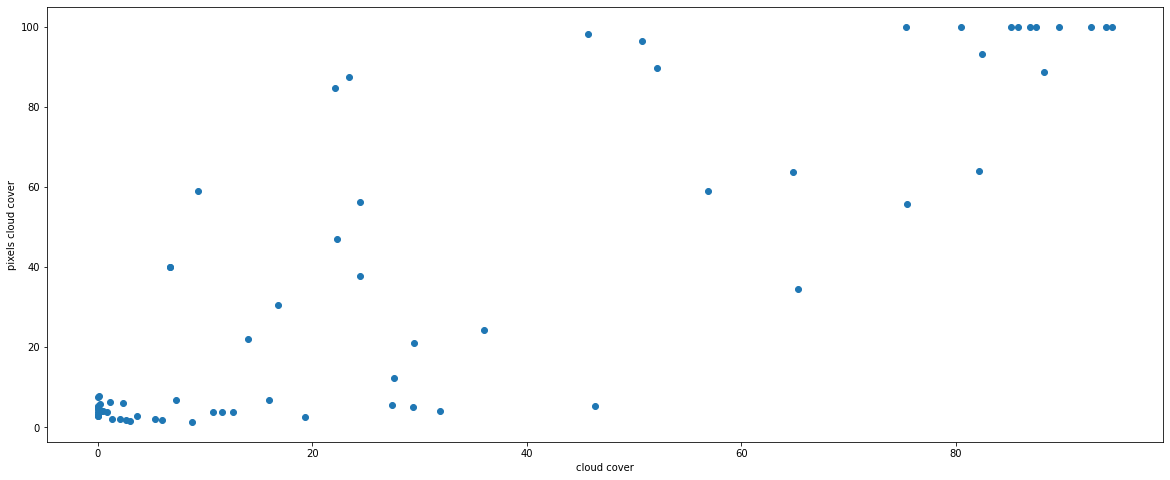

In [24]:
f, ax = plt.subplots(1,1,figsize=(20,8))
ax.scatter(df['Cloud Cover'],df['Chip Cloud Pct'])
ax.set_xlabel('cloud cover')
ax.set_ylabel('pixels cloud cover')

Get the URL to the 10m resolution visual [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image.

This HREF is a URL is the location of the asset data on Azure Blob Storage. In order to read the data, we'll need to retrieve a Shared Access Signature and supply it as a query parameter. These tokens are generated from the Planetary Computer Data Access API.

We use the planetary-computer package to "sign" our asset HREF with a generated token:

In [63]:
for i, station in gdf.iterrows():
    site = str(station.site_no).zfill(8)
    url = f'az://{container}/stations/{site}/{site}.csv'
    print(url)
    df = pd.read_csv(url, storage_options=storage_options) 
    df['Date-Time'] = pd.to_datetime(df['Date-Time'])
    df = df.sort_values(by='Date-Time')
    #Define the aoi and time range to filter images with. 
    area_of_interest, time_of_interest = get_spacetime_bounds(station)
    search = build_catalog(area_of_interest, time_of_interest)
    scene_query = df.iloc[1] #here we are testing for a cloud threshold
    #loop here
    visual_href = pc.sign(scene_query['visual-href'])
    scl_href = pc.sign(scene_query['scl-href'])

az://usgs-data/stations/06818000/06818000.csv
84 Items found


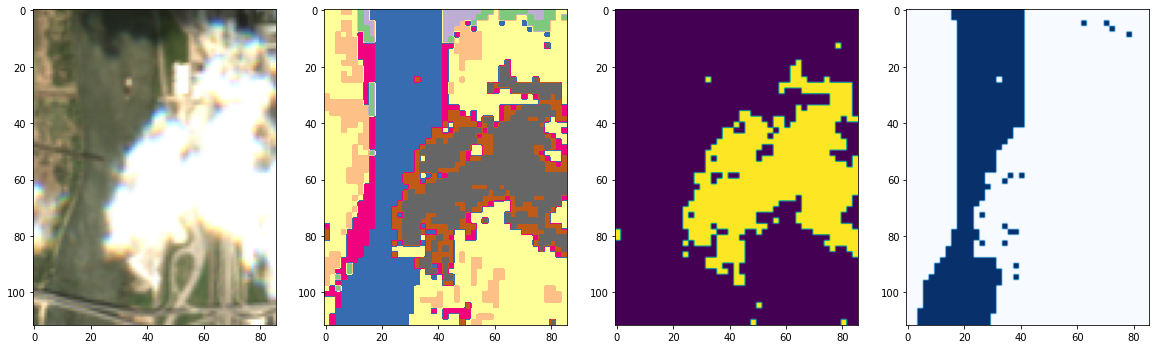

In [29]:
with rasterio.open(scl_href) as ds:    
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
    scl = band_data[0].repeat(2, axis=0).repeat(2, axis=1)

with rasterio.open(visual_href) as ds:    
    aoi_bounds = featureS.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)
    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    w = img.size[0]; h = img.size[1]; aspect = w/h
    #target_w = img.size[0]*2; target_h = (int)(target_w/aspect)
    target_w = scl.shape[1]; target_h = scl.shape[0]
    img = img.resize((target_w,target_h),Image.BILINEAR)
    

f, ax = plt.subplots(1,4, figsize=(20,20))
cloud_mask = scl>7
water_mask = (scl==6)
ax[0].imshow(img)
ax[1].imshow(scl, cmap='Accent')
ax[2].imshow(cloud_mask)
ax[3].imshow(water_mask, cmap='Blues')
    #we can download the image chips here and place them in the usgs-data/{site_no}/

In [17]:
np.mean(np.array(img)[water_mask], axis=0)

array([95.30862647, 99.33919598, 79.34924623])

In [25]:
a = rasterio.open(visual_href).read()

In [26]:
a.shape

(3, 10980, 10980)

In [27]:
a.size *a.itemsize * 1e-6 

361.6812

### all bands require 120.5604 mb 
sentinel 2 has b2, b3, b4, and b8 as 10m resolution and classification at 20m which is (1, 5490, 5490) requires only 30.1401 mb

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting. Given the bounds, we will select the a nxn image around our point of interest

We might be able to create a small semantic segmentation model using our classification layer and then run that first on a scene from landsat...

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,20))
mask = water_mask[..., np.newaxis] * np.ones(np.array(img).shape).astype('bool')
#water = np.ma.MaskedArray(np.array(img), mask=~mask)
water = np.array(img)
water[~mask] =255 
ax.imshow(water)

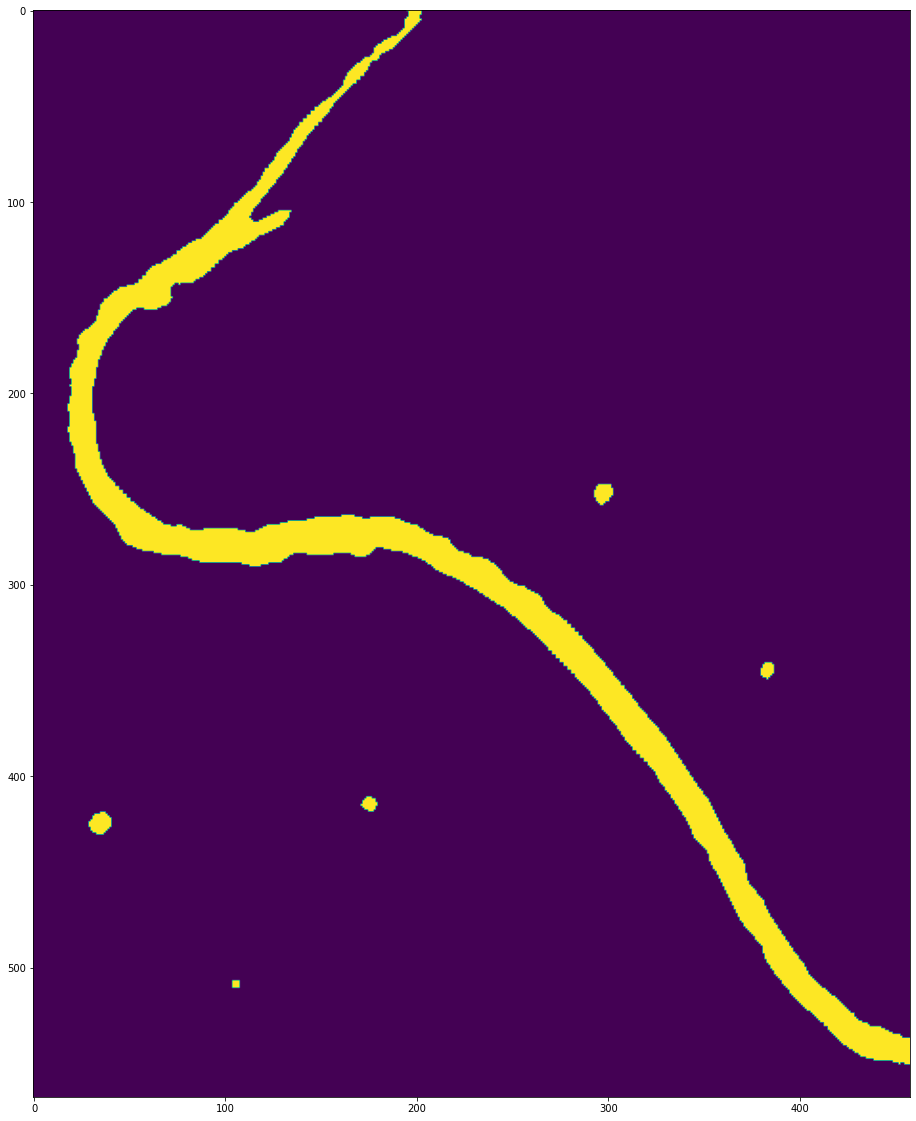

In [470]:
from scipy import ndimage
from skimage import filters
from skimage import restoration
f, ax = plt.subplots(1,1, figsize=(20,20))
#filt = restoration.denoise_tv_chambolle(mask,weight=1.8)
filt = ndimage.binary_erosion(mask[...,0], structure=np.ones((3,3)))
filt = ndimage.median_filter(filt, 9)
ax.imshow(filt)

In [101]:
#we might add a line to the gdf to include total number of cloud free chips?
#task is to open each site_no and the get the df of the estimates and then look at the cloud cover average
date_range_list = []
cloudless_count_list = []
site_no_list = []
for i, station in gdf.iterrows():
    site = str(station.site_no).zfill(8)
    url = f'az://{container}/stations/{site}/{site}.csv' #zero pad 8 digits for site_no
    try:
        df = pd.read_csv(url, storage_options=storage_options) 
        df['Date-Time'] = pd.to_datetime(df['Date-Time'])
        df = df.sort_values(by='Date-Time')
        if len(df)>0:
            #Define the aoi and time range to filter images with. 
            area_of_interest, time_of_interest = get_spacetime_bounds(station)
            cloud_thr = 5
            cloud_chip_count = len(df[df['Chip Cloud Pct']<cloud_thr])
            cloudless_count_list.append(cloud_chip_count)
            date_range_list.append(time_of_interest)
            site_no_list.append(int(site))
    except:
        print(f'{url} does not exist')
    
meta = pd.DataFrame({'site_no':site_no_list, 'cloudless_img_count':cloudless_count_list, 'date_range':date_range_list})
station_url = f'az://{container}/station_img_metadata.csv'
gdf.merge(meta, on='site_no').to_csv(station_url, storage_options=storage_options, index=False )

az://usgs-data/stations/06893390/06893390.csv does not exist
